<a href="https://colab.research.google.com/github/koyel-cy/breast_cancer_prediction_using_Resnet/blob/master/BreaKHis_RESNET.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
! pip install kaggle

In [ ]:
!cp /content/kaggle.json ~/.kaggle/

cp: cannot create regular file '/root/.kaggle/': Not a directory


In [ ]:
! mkdir ~/.kaggle

In [ ]:
! cp kaggle.json ~/.kaggle/

In [ ]:
! chmod 600 ~/.kaggle/kaggle.json

In [ ]:
! kaggle datasets download -d forderation/breakhis-400x

 98% 787M/803M [00:07<00:00, 71.5MB/s]
100% 803M/803M [00:07<00:00, 116MB/s] 


In [ ]:
%%capture
!unzip breakhis-400x.zip

In [ ]:
import os
import gc
import cv2
import json
import math
import scipy
import itertools
import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt
from PIL import Image
from keras import layers
from tensorflow.keras.applications import MobileNet, DenseNet201, InceptionV3, NASNetLarge, InceptionResNetV2, NASNetMobile
from keras import layers
from keras.layers import Dense,Dropout,Activation,Add,MaxPooling2D,Conv2D,Flatten,BatchNormalization
from keras.callbacks import Callback, ModelCheckpoint, ReduceLROnPlateau, TensorBoard
from keras.preprocessing.image import ImageDataGenerator
from keras.preprocessing import image
from keras.utils.np_utils import to_categorical
from keras.models import Sequential
from tensorflow.keras.optimizers import Adam
from sklearn import metrics
from sklearn.model_selection import train_test_split
from sklearn.metrics import cohen_kappa_score, accuracy_score
from tqdm import tqdm
from keras import backend as K
from functools import partial
from collections import Counter
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()
%matplotlib inline

In [ ]:
BATCH_SIZE = 32

In [ ]:
train_generator = ImageDataGenerator(
        zoom_range=2,
        rotation_range = 90,
        horizontal_flip=True,
        vertical_flip=True,
)

In [ ]:
def Dataset_loader(DIR, RESIZE, sigmaX=10):
    IMG = []
    read = lambda imname: np.asarray(Image.open(imname).convert("RGB"))
    for IMAGE_NAME in tqdm(os.listdir(DIR)):
        PATH = os.path.join(DIR,IMAGE_NAME)
        _, ftype = os.path.splitext(PATH)
        if ftype == ".png":
            img = read(PATH)
           
            img = cv2.resize(img, (RESIZE,RESIZE))
           
            IMG.append(np.array(img))
    return IMG

In [ ]:
benign_train = np.array(Dataset_loader('BreaKHis 400X/train/benign',224))
malign_train = np.array(Dataset_loader('BreaKHis 400X/train/malignant',224))
benign_test = np.array(Dataset_loader('BreaKHis 400X/test/benign',224))
malign_test = np.array(Dataset_loader('BreaKHis 400X/test/malignant',224))

100%|██████████| 369/369 [00:04<00:00, 74.04it/s]


In [ ]:
# Create labels
benign_train_label = np.zeros(len(benign_train))
malign_train_label = np.ones(len(malign_train))
benign_test_label = np.zeros(len(benign_test))
malign_test_label = np.ones(len(malign_test))
label =  {0:"benign",1:"malignant"}

In [ ]:
# Merge data 
X_train = np.concatenate((benign_train, malign_train), axis = 0)
Y_train = np.concatenate((benign_train_label, malign_train_label), axis = 0)
X_test = np.concatenate((benign_test, malign_test), axis = 0)
Y_test = np.concatenate((benign_test_label, malign_test_label), axis = 0)

In [ ]:
# Shuffle train data
s = np.arange(X_train.shape[0])
np.random.shuffle(s)
X_train = X_train[s]
Y_train = Y_train[s]

In [ ]:
# Shuffle test data
s = np.arange(X_test.shape[0])
np.random.shuffle(s)
X_test = X_test[s]
Y_test = Y_test[s]

In [ ]:
# To categorical
Y_train = to_categorical(Y_train, num_classes= 2)
Y_test = to_categorical(Y_test, num_classes= 2)

In [ ]:
x_train, x_val, y_train, y_val = train_test_split(
    X_train, Y_train, 
    test_size=0.2, 
    random_state=11
)

In [ ]:
#build cnn
def build_model(backbone, lr=1e-4):
    model = Sequential()
    model.add(backbone)
    model.add(Conv2D(16, (3, 3), padding="valid", activation="relu"))
    model.add(MaxPooling2D(pool_size=(2, 2),strides=(1, 1), padding="same"))
    model.add(Conv2D(32, (3, 3), padding="valid", activation="relu"))
    model.add(MaxPooling2D(pool_size=(2, 2),strides=(1, 1), padding="same"))
    model.add(Conv2D(64, (3, 3), padding="valid", activation="relu"))
    model.add(MaxPooling2D(pool_size=(2, 2),strides=(1, 1), padding="same"))
    model.add(Flatten())
    model.add(layers.Dropout(0.5))
    model.add(layers.BatchNormalization())
    model.add(layers.Dense(2, activation='sigmoid'))
    
    model.compile(
        loss='binary_crossentropy',
        optimizer=Adam(lr=lr),
        metrics=['accuracy']
    )
    
    return model

In [ ]:
K.clear_session()
gc.collect()

26

In [ ]:
model = DenseNet201(
    weights='imagenet',
    include_top=False,
    input_shape=(224,224,3)
)

74850304/74836368 [==============================] - 0s 0us/step


In [ ]:
model = build_model(model ,lr = 1e-4)

/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


In [ ]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 densenet201 (Functional)    (None, 7, 7, 1920)        18321984  
                                                                 
 conv2d (Conv2D)             (None, 5, 5, 16)          276496    
                                                                 
 max_pooling2d (MaxPooling2D  (None, 5, 5, 16)         0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 3, 3, 32)          4640      
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 3, 3, 32)         0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 1, 1, 64)          1

In [ ]:
history = model.fit(
    train_generator.flow(x_train, y_train, batch_size=BATCH_SIZE),
    steps_per_epoch=x_train.shape[0] / BATCH_SIZE,
    epochs=50,
    validation_data=(x_val, y_val)
)

Epoch 1/50
28/28 [==============================] - 63s 956ms/step - loss: 0.7637 - accuracy: 0.5381 - val_loss: 0.6563 - val_accuracy: 0.7304
Epoch 2/50
28/28 [==============================] - 17s 569ms/step - loss: 0.6659 - accuracy: 0.6471 - val_loss: 0.5698 - val_accuracy: 0.7522
Epoch 3/50
28/28 [==============================] - 17s 585ms/step - loss: 0.5851 - accuracy: 0.7397 - val_loss: 0.6022 - val_accuracy: 0.7261
Epoch 4/50
28/28 [==============================] - 17s 584ms/step - loss: 0.4873 - accuracy: 0.8159 - val_loss: 0.6425 - val_accuracy: 0.7217
Epoch 5/50
28/28 [==============================] - 17s 578ms/step - loss: 0.4523 - accuracy: 0.8410 - val_loss: 0.5306 - val_accuracy: 0.7565
Epoch 6/50
28/28 [==============================] - 17s 589ms/step - loss: 0.4154 - accuracy: 0.8584 - val_loss: 0.4008 - val_accuracy: 0.8174
Epoch 7/50
28/28 [==============================] - 17s 581ms/step - loss: 0.3901 - accuracy: 0.8649 - val_loss: 0.3365 - val_accuracy: 0.8522

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
accuracy = history.history['accuracy']
val_accuracy = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(loss) + 1)

<Figure size 432x288 with 0 Axes>

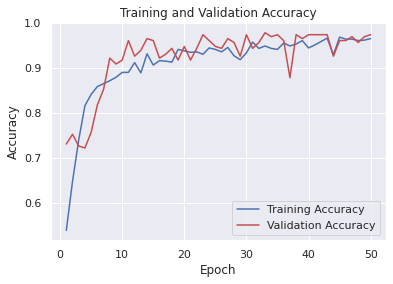

<Figure size 432x288 with 0 Axes>

In [ ]:
#accuracy plot
plt.plot(epochs, accuracy, color='b', label='Training Accuracy')
plt.plot(epochs, val_accuracy, color='r', label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend()
plt.figure()

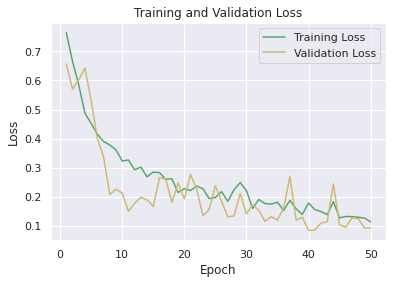

In [ ]:
#loss plot
plt.plot(epochs, loss, color='g', label='Training Loss')
plt.plot(epochs, val_loss, color='y', label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.show()

In [ ]:
Y_pred = model.predict(X_test)
Y_pred = np.argmax(Y_pred,axis=1)
Y_pred

array([1, 0, 1, 0, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 0, 1, 1, 0, 1, 0, 1, 1,
       1, 0, 1, 1, 0, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       0, 1, 1, 0, 1, 1, 0, 1, 0, 0, 0, 0, 1, 1, 1, 0, 0, 1, 0, 1, 1, 1,
       1, 1, 1, 0, 0, 0, 1, 0, 1, 1, 0, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 1, 0, 0, 1, 1, 1, 1, 1, 1, 0, 1,
       1, 1, 0, 1, 0, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 0,
       1, 0, 1, 0, 1, 0, 1, 1, 1, 1, 0, 1, 1, 1, 1, 0, 1, 1, 1, 1, 0, 1,
       1, 1, 0, 1, 1, 0, 0, 0, 1, 1, 1, 1, 0, 0, 0, 1, 1, 1, 1, 0, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 0, 0, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 1, 1, 1, 1, 0, 1, 1, 1, 0, 1, 1,
       1, 0, 1, 1, 0, 0, 0, 1, 1, 0, 1, 0, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1,
       0, 1, 1, 1, 1, 0, 1, 1, 1, 0, 1, 0, 1, 1, 0, 0, 1, 1, 0, 0, 0, 1,
       0, 1, 1, 0, 1, 1, 0, 0, 1, 1, 1, 1, 1, 0, 1, 0, 0, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 1,

In [ ]:
tta_steps = 10
predictions = []

for i in tqdm(range(tta_steps)):
    preds = model.predict(train_generator.flow(X_test, batch_size=BATCH_SIZE, shuffle=False),
                                    steps = len(X_test)/BATCH_SIZE)
    
    predictions.append(preds)
    gc.collect()
    
Y_pred_tta = np.mean(predictions, axis=0)

100%|██████████| 10/10 [01:16<00:00,  7.63s/it]


[0]
benign


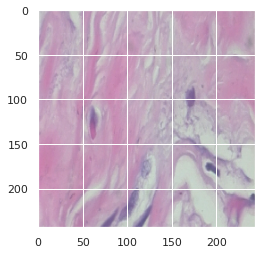

In [ ]:
#test model 1 
img_ = image.load_img("BreaKHis 400X/train/benign/SOB_B_A-14-22549AB-400-002.png", target_size=(244, 244))
imag = image.img_to_array(img_)
imag = np.expand_dims(imag, axis=0)
pred = model.predict(imag)
pred = np.argmax(pred,axis=1)
print(pred)
print(label[pred[0]])
plt.imshow(img_)
model.save('final_model.h5')

[1]
malignant


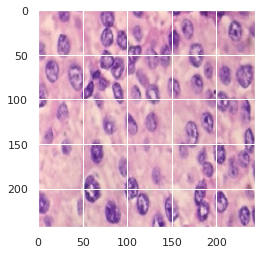

In [ ]:
#test model 4
img_ = image.load_img("BreaKHis 400X/test/malignant/SOB_M_DC-14-11031-400-003.png", target_size=(244, 244))
imag = image.img_to_array(img_)
imag = np.expand_dims(imag, axis=0)
pred = model.predict(imag)
pred = np.argmax(pred,axis=1)
print(pred)
print(label[pred[0]])
plt.imshow(img_)

[1]
malignant


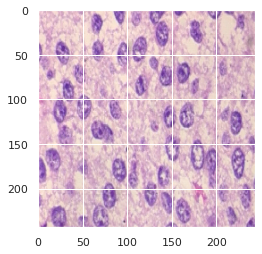

In [ ]:
#test model 5
img_ = image.load_img("BreaKHis 400X/train/malignant/SOB_M_DC-14-11031-400-007.png", target_size=(244, 244))
imag = image.img_to_array(img_)
imag = np.expand_dims(imag, axis=0)
pred = model.predict(imag)
pred = np.argmax(pred,axis=1)
print(pred)
print(label[pred[0]])
plt.imshow(img_)

[0]
benign


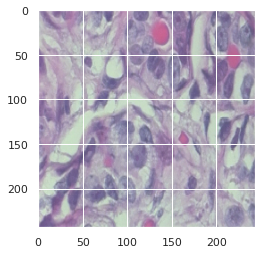

In [ ]:
#test model 6
img_ = image.load_img("BreaKHis 400X/train/benign/SOB_B_A-14-22549AB-400-022.png", target_size=(244, 244))
imag = image.img_to_array(img_)
imag = np.expand_dims(imag, axis=0)
pred = model.predict(imag)
pred = np.argmax(pred,axis=1)
print(pred)
print(label[pred[0]])
plt.imshow(img_)

[1]
malignant


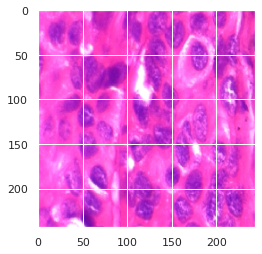

In [ ]:
#test model 3
img_ = image.load_img("BreaKHis 400X/train/malignant/SOB_M_DC-14-9461-400-006.png", target_size=(244, 244))
imag = image.img_to_array(img_)
imag = np.expand_dims(imag, axis=0)
pred = model.predict(imag)
pred = np.argmax(pred,axis=1)
print(pred)
print(label[pred[0]])
plt.imshow(img_)

[0]
benign


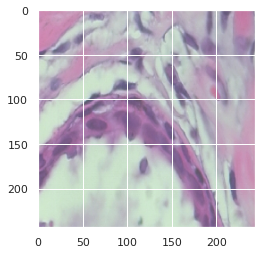

In [ ]:
#test model 2
img_ = image.load_img("BreaKHis 400X/test/benign/SOB_B_A-14-22549AB-400-003.png", target_size=(244, 244))
imag = image.img_to_array(img_)
imag = np.expand_dims(imag, axis=0)
pred = model.predict(imag)
pred = np.argmax(pred,axis=1)
print(pred)
print(label[pred[0]])
plt.imshow(img_)